In [1]:
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os

from prototype_data import get_dataset
from prototype_runs import Experiment
#from prototype_plots import Report, plot2D, transform_label, plot_elbow_curve
%run prototype_plots.py
random_state=0
dataset = 'cifar10'
train_size = 500
N = n_classes = 10
random_state=0

/mnt/Data/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
inpath = dataset + '_hparams'
results_path = os.path.join("prototype_results", inpath)
os.makedirs(results_path, exist_ok=True)
print(results_path)

prototype_results/cifar10_hparams


# Study of hyper parameters - Cluster and classification of inceptionV3 features

## Dataset

Experiments on one common episode with 10 classes to explore hyper parameters and get a feel of their sensibility.

Bellow we sample an episode on the data.

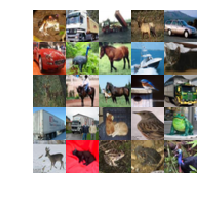

In [4]:
dataset_obj = get_dataset(dataset, random_state)
X_imgs, X, y = dataset_obj.gen_data(N=N, plot=True)
skf, skf_cv = dataset_obj.splitters(train_size=train_size, cv_repeats=5)
train, test = list(skf.split(X, y))[0]
plt.gcf().set_size_inches(5,3)
plt.savefig(os.path.join(results_path, dataset+'_examples.eps'), dpi=300)

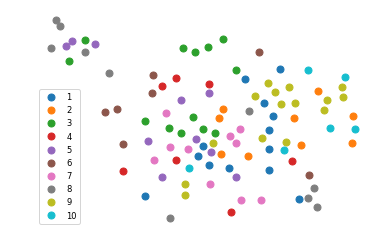

In [5]:
np.random.seed(0)
plot2D(X, y, method='tsne', perplexity=10)
plt.title('')
#plt.tick_params(length=0,labelsize=0)
plt.axis("off")
fig = plt.gcf()
fig.set_size_inches(6,4)
plt.legend(loc='best', fontsize='small')
plt.savefig(os.path.join(results_path,dataset+"_TSNE_example.eps"))

### Elbow curve

In [6]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
plt.figure()
out = []
normalizers = [False, MinMaxScaler, StandardScaler]
for i, normalize in enumerate(normalizers):
    o = plot_elbow_curve(
        X[train], y[train], n_clusters=np.array([5] + list(range(10,80,10))),
        cv=skf_cv, normalize=normalize, random_state=random_state,
        plot=False)
    out.append(o)

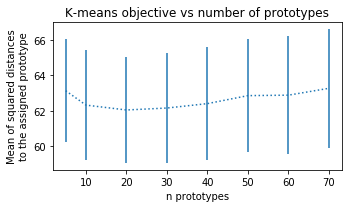

In [7]:
plt.figure(figsize=(5,3))
plt.errorbar(*out[1], linestyle=':')
plt.title('K-means objective vs number of prototypes')
plt.xlabel('n prototypes')
plt.ylabel('Mean of squared distances\nto the assigned prototype')
plt.tight_layout()
plt.savefig(os.path.join(results_path, dataset+'_elbow.pdf'), dpi=300)

### Normalizations

Text(0.5,0.98,'K-means objective vs number of prototypes')

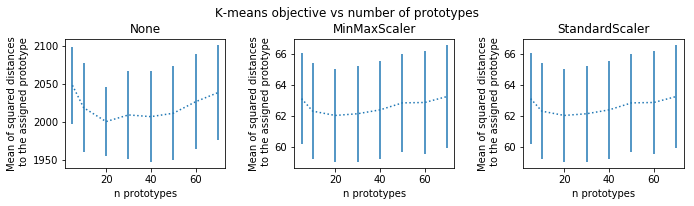

In [8]:
plt.figure(figsize=(10,3))
for i, normalize in enumerate(normalizers):
    plt.subplot(1,3,i+1)
    if not normalize:
        label = 'None'
    else:
        label = normalize.__name__.split('.')[-1]
    plt.errorbar(*out[i], linestyle=':', label=label)
    plt.title(label)
    plt.xlabel('n prototypes')
    plt.ylabel('Mean of squared distances\n to the assigned prototype')
    #plt.legend(loc='best')
plt.tight_layout(pad=2)
plt.suptitle('K-means objective vs number of prototypes')

1.8033333333333332 hours total


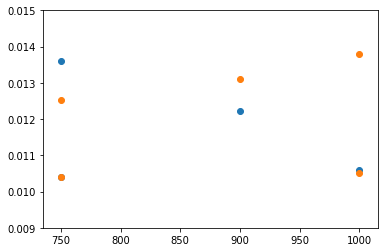

In [9]:
# time spent on each experiemnt bellow, for register
exp = ['base', 'cat', 'class_weight', 'shortcut', 'both']
n_fits = np.array([1000, 1000, 750, 750, 900])
t_l1 = np.array([10.6, 15.3, 7.8, 10.2, 11.0]) # min
t_l2 = np.array([10.5, 13.8, 7.8, 9.4, 11.8]) # min
plt.scatter(n_fits, t_l1/n_fits)
plt.scatter(n_fits, t_l2/n_fits)
plt.ylim((0.009,0.015))
print((t_l1.sum()+t_l2.sum())/60, 'hours total')

## Base model on 10 classes

Exploring hyperparams on a large interval.

When plotting the closest images, also annotated information on closest and farthest training point (attributed to that prototype). When no point was atributed (indicated by 0 pts), distances correspond to closest and farthest point over all training points.

In [10]:
ex = Experiment(
        path = os.path.join(inpath, 'analysing_base_models'),
        model_list=['l1_plain','l2_plain'],
        n_Cs=10, Cs_lim=(-3,8),
        n_n_clusters=10, n_clusters_lim=(1,5),
        dataset = dataset,
        train_size=train_size,
        n_splits=1,
        n_classes=n_classes,
        random_seed=random_state)
out = ex.run_multiple_splits(return_models=True)
exp_info = out['info']
res_dict = out['results']
models = out['models']
dataset_obj = exp_info['dataset']
X_imgs, X, y = dataset_obj.gen_data()
skf, skf_cv = exp_info['skf'], exp_info['skf_cv']

{'model_list': ['l1_plain', 'l2_plain'], 'path': './prototype_results/cifar10_hparams/analysing_base_models', 'dataset': <prototype_data.Cifar10 object at 0x7f1ff146b048>, 'n_classes': 10, 'n_episodes': None, 'n_splits': 1, 'random_seed': 0, 'train_size': 500, 'skf': StratifiedShufflePredefinedTestSplit(n_splits=1, random_state=0,
                   test_fold=array([-1, -1, ...,  0,  0]), train_size=500), 'skf_cv': <sklearn.model_selection._split.RepeatedStratifiedKFold object at 0x7f1ff14af2e8>, 'n_jobs': 2, 'cluster_classify_kwargs': {'n_Cs': 10, 'Cs_lim': (-3, 8), 'n_n_clusters': 10, 'n_clusters_lim': (1, 5), 'n_class_weights': 3, 'class_weight_lim': (0.0, 2.0), 'n_shortcut': 1, 'shortcut_lim': (0, 1), 'shortcut_scale': 'linear'}}
Results at ./prototype_results/cifar10_hparams/analysing_base_models/1_splits_500_train_size/results.pd.pkl
Running models: ['l1_plain', 'l2_plain']
Fitting 10 folds for each of 100 candidates, totalling 1000 fits


[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   30.3s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:  2.9min
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:  6.5min
[Parallel(n_jobs=2)]: Done 796 tasks      | elapsed: 12.0min
[Parallel(n_jobs=2)]: Done 1000 out of 1000 | elapsed: 15.2min finished


Fitting 10 folds for each of 100 candidates, totalling 1000 fits


[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   32.3s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:  2.9min
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:  6.5min
/mnt/Data/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:712: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/mnt/Data/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:712: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/mnt/Data/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:712: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/mnt/Data/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:712: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", Convergen

/mnt/Data/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:712: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/mnt/Data/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:712: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/mnt/Data/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:712: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/mnt/Data/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:712: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/mnt/Data/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:712: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of

/mnt/Data/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:712: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/mnt/Data/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:712: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/mnt/Data/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:712: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/mnt/Data/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:712: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/mnt/Data/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:712: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of

/mnt/Data/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:712: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/mnt/Data/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:712: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/mnt/Data/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:712: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/mnt/Data/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:712: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/mnt/Data/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:712: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of

/mnt/Data/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:712: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/mnt/Data/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:712: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/mnt/Data/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:712: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/mnt/Data/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:712: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/mnt/Data/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:712: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of

/mnt/Data/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:712: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/mnt/Data/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:712: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/mnt/Data/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:712: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/mnt/Data/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:712: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/mnt/Data/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:712: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of

/mnt/Data/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:712: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/mnt/Data/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:712: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/mnt/Data/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:712: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/mnt/Data/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:712: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/mnt/Data/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:712: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of

/mnt/Data/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:712: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/mnt/Data/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:712: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/mnt/Data/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:712: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/mnt/Data/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:712: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/mnt/Data/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:712: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of

/mnt/Data/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:712: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/mnt/Data/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:712: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/mnt/Data/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:712: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/mnt/Data/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:712: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/mnt/Data/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:712: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of

### Train split 0

In [11]:
reportl1 = Report('analysing_base_models', models, model='l1_plain', split=0, splitter=skf, N=N, directory=results_path)
reportl2 = Report('analysing_base_models', models, model='l2_plain', split=0, splitter=skf, N=N, directory=results_path)

In [12]:
for train, test in skf.split(X, y):
    print('l1',reportl1.model.score(X[test],y[test]),'l2',reportl2.model.score(X[test],y[test]))

l1 0.6755 l2 0.696


#### L1 penalty

In [13]:
reportl1.wc_stats()
reportl1.report(X,y)

Wc sparsity @ tol=0.1 0.008000000000000007
Wc mean:  0.008556056428393318 std:  4.679739757640797
best Params {'classify__C': 1291.5496650148852, 'classify__penalty': 'l1', 'classify__shortcut': 0.0, 'classify__solver': 'saga', 'classify__tol': 0.1, 'classify__use_shortcut': False, 'cluster__class_weight': 0.0, 'cluster__n_clusters': 50}
mean acuracy of best cv model:  0.5843999999999999
best model train accuracy:  0.704
holdout test accuracy:  0.6755


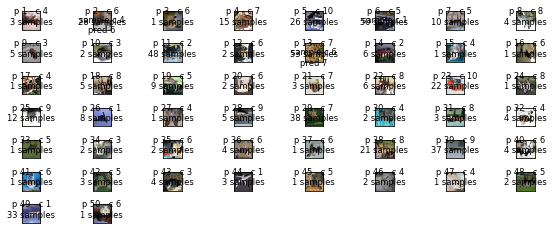

In [14]:
reportl1.closest_images(X_imgs, X, y, show_distances=False)
fig = plt.gcf()
fig.set_size_inches(8,3)
plt.tight_layout()

proto per class:  [ 3.09573598  2.07254289  4.11174893  7.77110265  6.86305722 11.76561076
  3.50406203  5.68334973  2.98653289  2.14625693]


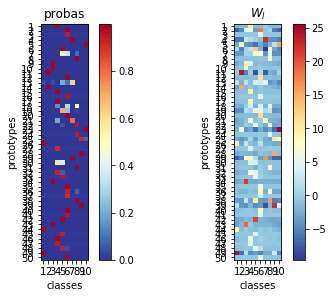

In [15]:
reportl1.visualize_weights()

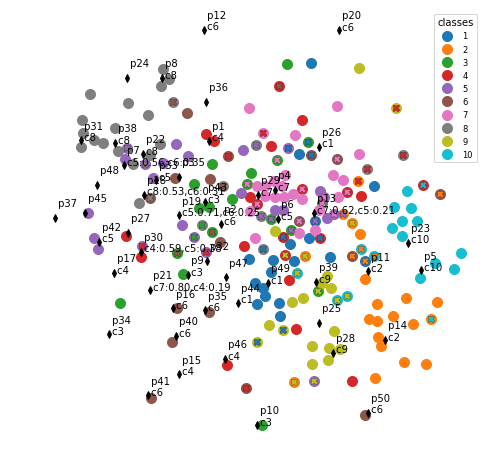

In [16]:
np.random.seed(0)
reportl1.plot2D(X,y, method='tsne', cluster_limits=False, arrows=False)
fig = plt.gcf()
fig.set_size_inches(8,8)
reportl1.savefig('plot2D_tsne.eps')

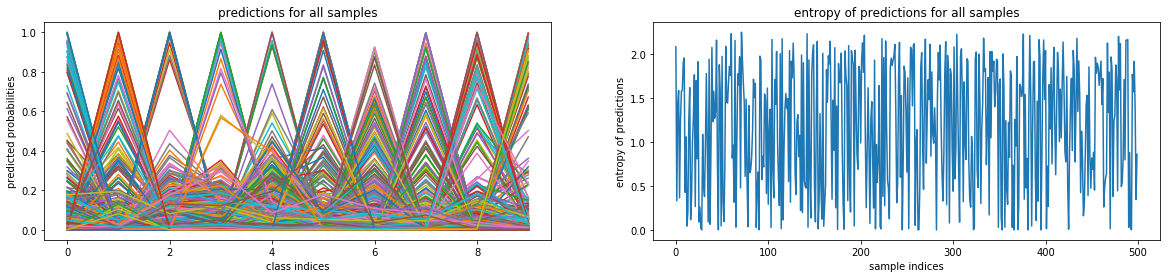

In [17]:
reportl1.entropy_per_sample(X,y)
plt.gcf().set_size_inches(20,4)

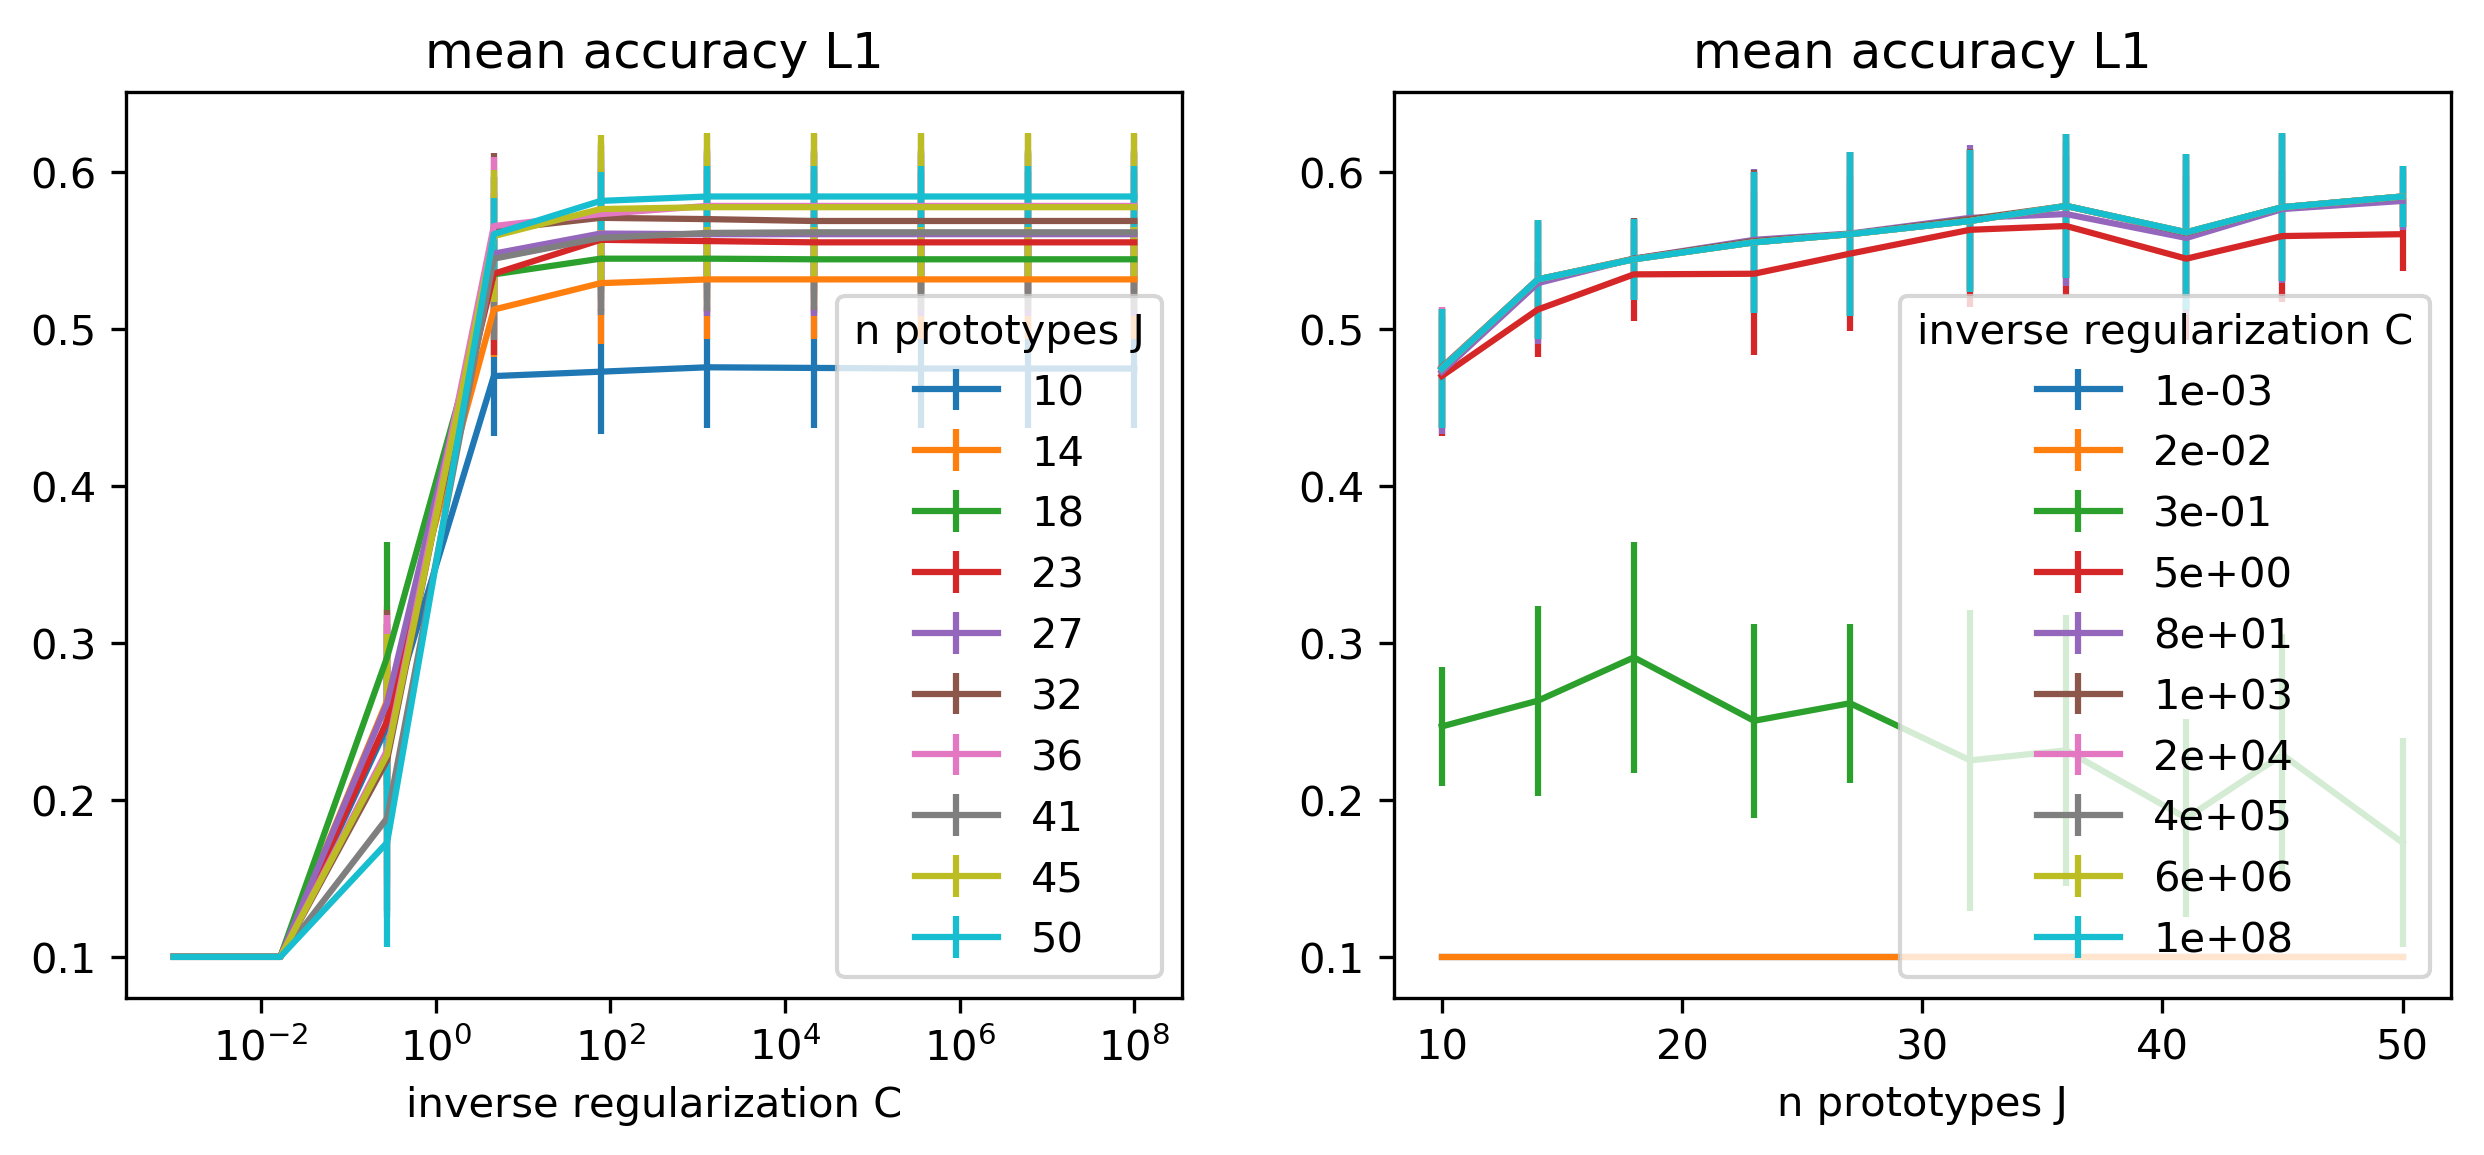

In [18]:
reportl1.main_parameter_grids()

#### L2 penalty

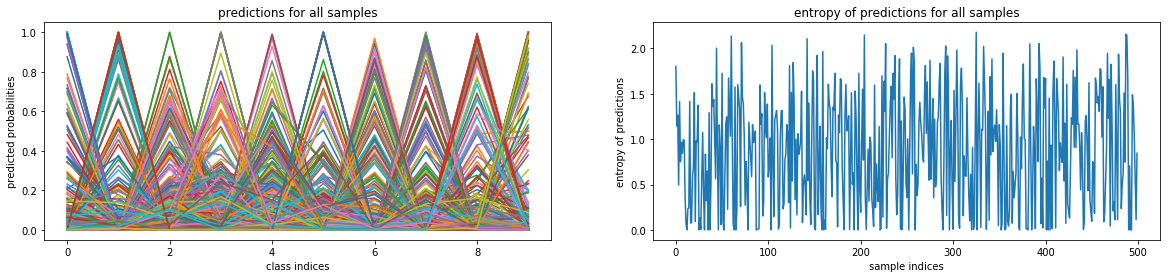

In [19]:
reportl2.entropy_per_sample(X,y)
plt.gcf().set_size_inches(20,4)

In [20]:
reportl2.wc_stats()
reportl2.report(X,y)

Wc sparsity @ tol=0.1 0.01666666666666672
Wc mean:  -3.0592812234115426e-15 std:  15.324858361847163
best Params {'classify__C': 1291.5496650148852, 'classify__penalty': 'l2', 'classify__shortcut': 0.0, 'classify__solver': 'lbfgs', 'classify__use_shortcut': False, 'cluster__class_weight': 0.0, 'cluster__n_clusters': 36}
mean acuracy of best cv model:  0.5868
best model train accuracy:  0.728
holdout test accuracy:  0.696


proto per class:  [3.78117346 1.00363842 2.71920073 5.65244571 3.83440511 8.38483659
 2.95755002 3.66167137 2.29171551 1.71336307]


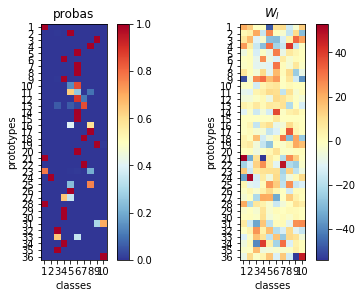

In [21]:
reportl2.visualize_weights()

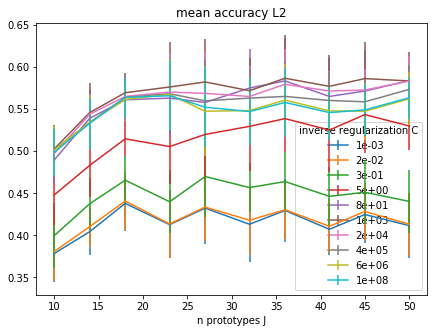

In [22]:
_ = reportl2.parameter_grid(index=['param_cluster__n_clusters'],
            columns=['param_classify__C'], fix='all')
plt.gcf().set_size_inches(7,5)
reportl2.savefig('n_clusters_C.eps')

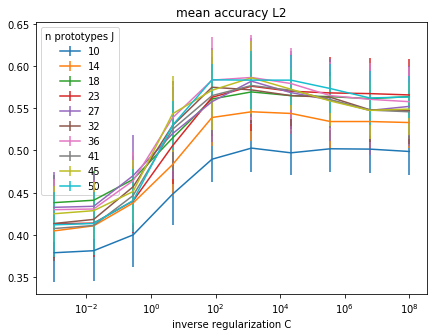

In [23]:
_ = reportl2.parameter_grid(index=['param_classify__C'],
            columns=['param_cluster__n_clusters'], fix='all')
plt.gcf().set_size_inches(7,5)
reportl2.savefig('C_n_clusters.eps')

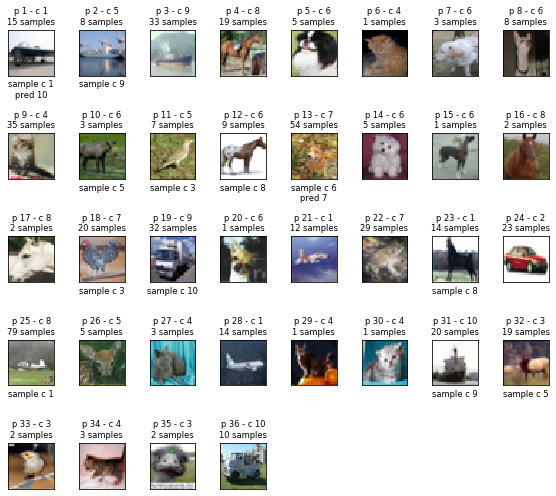

In [ ]:
reportl2.closest_images(X_imgs, X, y, show_distances=False)
fig = plt.gcf()
fig.set_size_inches(8,7)
plt.tight_layout()
reportl2.savefig('closest_images.eps')

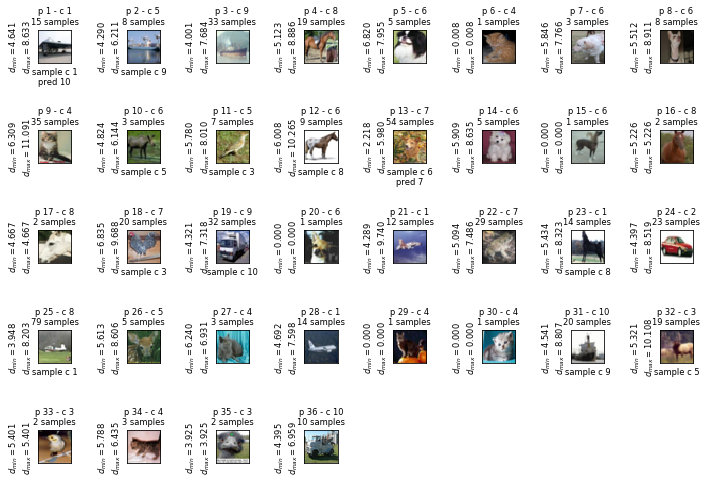

In [ ]:
reportl2.closest_images(X_imgs, X, y, show_distances=True)
fig = plt.gcf()
fig.set_size_inches(10,7)
plt.tight_layout()

In [ ]:
X[train].shape

(500, 2048)

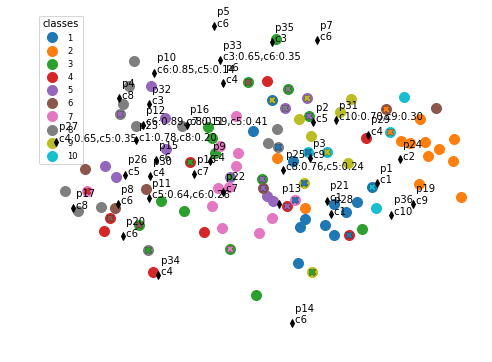

In [ ]:
np.random.seed(0)
reportl2.plot2D(X,y, method='tsne', cluster_limits=False, arrows=False,
               plot_n_samples=100)
fig = plt.gcf()
fig.set_size_inches(8,6)
reportl2.savefig('plot2D_tsne.eps')

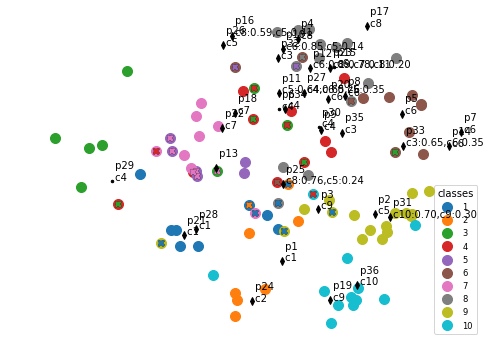

In [ ]:
np.random.seed(0)
reportl2.plot2D(X,y, method='tsne', split='test', 
                cluster_limits=False, arrows=False,
                plot_n_samples=100)
fig = plt.gcf()
fig.set_size_inches(8,6)
reportl2.savefig('plot2D_tsne_test.eps')

In [ ]:
# preds = reportl2.model.best_estimator_.predict(X)
# misclassified = np.ix_(reportl2.model.best_estimator_.predict(X)!=y)[0].tolist()
# prototype = reportl2.cluster.predict(reportl2.normalize.transform(X))
# ncols = 7
# nrows = int(np.ceil(len(misclassified)/ncols))
# ix = 0
# plt.figure(figsize=(12,5))
# for i in range(nrows):
#     for j in range(ncols):
#         if ix < len(misclassified):
#             miss_ix = misclassified[ix]
#             plt.subplot2grid((nrows, ncols), (i,j))
#             image = X_imgs[miss_ix,:,:]
#             plt.imshow(image, cmap='Greys_r')
#             plt.axis('off')
#             title = 'pred %s - proto %d\n(true %s)'% (preds[miss_ix]+1, prototype[miss_ix]+1, y[miss_ix]+1)
#             plt.title(title)
#             ix+=1
# plt.tight_layout()
# reportl2.savefig('misclassified.eps')

## Concatenating features and prototype compressed features

In [ ]:
ex = Experiment(
        path = os.path.join(inpath, 'analysing_concat_models'),
        model_list=['l1_cat','l2_cat'],
        n_Cs=10, Cs_lim=(-3,8),
        n_n_clusters=10, n_clusters_lim=(1,5),
        dataset = dataset,
        train_size=train_size,
        n_splits=1,
        n_classes=n_classes,
        random_seed=random_state)
out = ex.run_multiple_splits(return_models=True)
exp_info = out['info']
res_dict = out['results']
models = out['models']
dataset_obj = exp_info['dataset']
X_imgs, X, y = dataset_obj.gen_data()
skf, skf_cv = exp_info['skf'], exp_info['skf_cv']

{'model_list': ['l1_cat', 'l2_cat'], 'path': './prototype_results/cifar10_hparams/analysing_concat_models', 'dataset': <prototype_data.Cifar10 object at 0x7f1febb930b8>, 'n_classes': 10, 'n_episodes': None, 'n_splits': 1, 'random_seed': 0, 'train_size': 500, 'skf': StratifiedShufflePredefinedTestSplit(n_splits=1, random_state=0,
                   test_fold=array([-1, -1, ...,  0,  0]), train_size=500), 'skf_cv': <sklearn.model_selection._split.RepeatedStratifiedKFold object at 0x7f1febb93dd8>, 'n_jobs': 2, 'cluster_classify_kwargs': {'n_Cs': 10, 'Cs_lim': (-3, 8), 'n_n_clusters': 10, 'n_clusters_lim': (1, 5), 'n_class_weights': 3, 'class_weight_lim': (0.0, 2.0), 'n_shortcut': 1, 'shortcut_lim': (0, 1), 'shortcut_scale': 'linear'}}
Results at ./prototype_results/cifar10_hparams/analysing_concat_models/1_splits_500_train_size/results.pd.pkl
Running models: ['l1_cat', 'l2_cat']
Fitting 10 folds for each of 100 candidates, totalling 1000 fits


[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   51.1s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:  5.0min
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed: 12.3min
[Parallel(n_jobs=2)]: Done 796 tasks      | elapsed: 23.3min
[Parallel(n_jobs=2)]: Done 1000 out of 1000 | elapsed: 29.6min finished


Fitting 10 folds for each of 100 candidates, totalling 1000 fits


[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:  1.1min
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:  7.6min
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed: 22.7min
[Parallel(n_jobs=2)]: Done 796 tasks      | elapsed: 32.7min
[Parallel(n_jobs=2)]: Done 1000 out of 1000 | elapsed: 37.6min finished


### Train/test split 0

In [ ]:
reportl1 = Report('analysing_concat_models', models, model='l1_cat', splitter=skf, N=N, directory=results_path)
reportl2 = Report('analysing_concat_models', models, model='l2_cat', splitter=skf, N=N, directory=results_path)

In [ ]:
for train, test in skf.split(X, y):
    print('l1',reportl1.model.score(X[test],y[test]),'l2',reportl2.model.score(X[test],y[test]))

l1 0.7529 l2 0.7344


#### L1 penalty

In [ ]:
reportl1.wc_stats()
reportl1.report(X,y)

Wc sparsity @ tol=0.1 0.9785400390625
Wc mean:  0.0007817253149746432 std:  0.03235820686544866
best Params {'classify__C': 4.641588833612782, 'classify__penalty': 'l1', 'classify__shortcut': 'cat', 'classify__solver': 'saga', 'classify__tol': 0.1, 'classify__use_shortcut': True, 'cluster__class_weight': 0.0, 'cluster__n_clusters': 10}
mean acuracy of best cv model:  0.7156
best model train accuracy:  0.972
holdout test accuracy:  0.7529


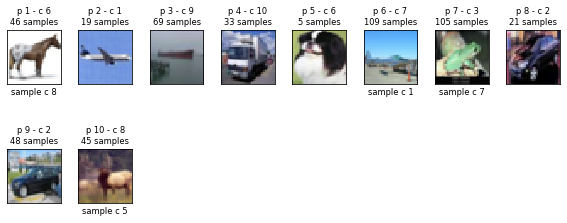

In [ ]:
reportl1.closest_images(X_imgs, X, y, show_distances=False)
fig = plt.gcf()
fig.set_size_inches(8,4)
plt.tight_layout()

proto per class:  [1.25851323 1.47577739 0.58061026 0.70593432 0.49885612 1.88945232
 0.33935391 1.16370015 0.84921967 1.23858264]


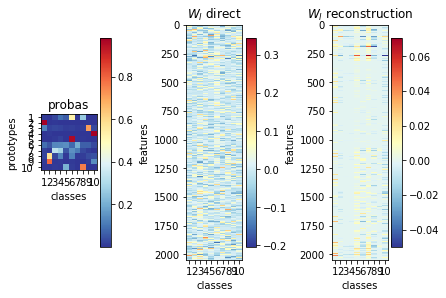

In [ ]:
reportl1.visualize_weights()

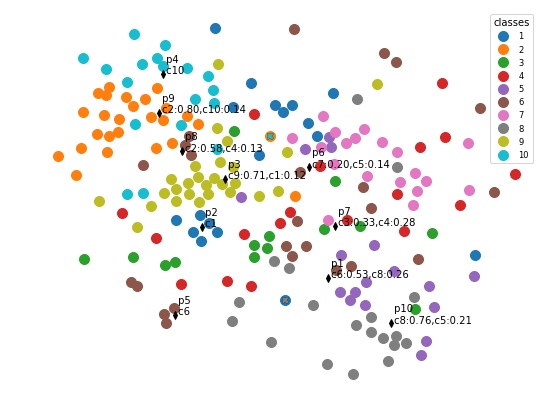

In [ ]:
reportl1.plot2D(X,y, method='tsne', cluster_limits=False, arrows=False,
               random_state=random_state)
fig = plt.gcf()
fig.set_size_inches(9,7)
reportl1.savefig('plot2D_tsne.eps')

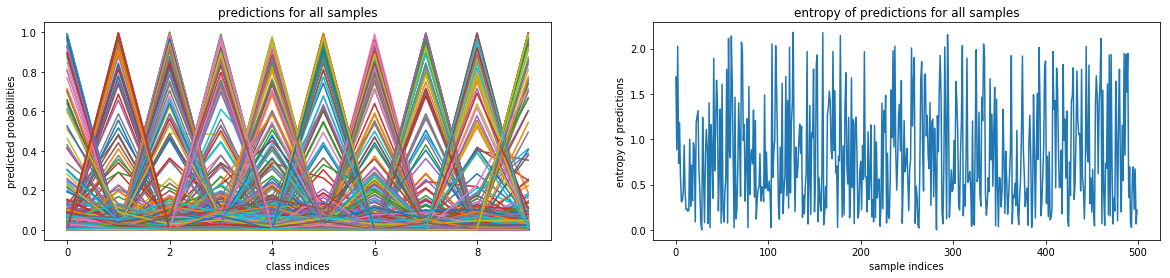

In [ ]:
reportl1.entropy_per_sample(X,y)
plt.gcf().set_size_inches(20,4)

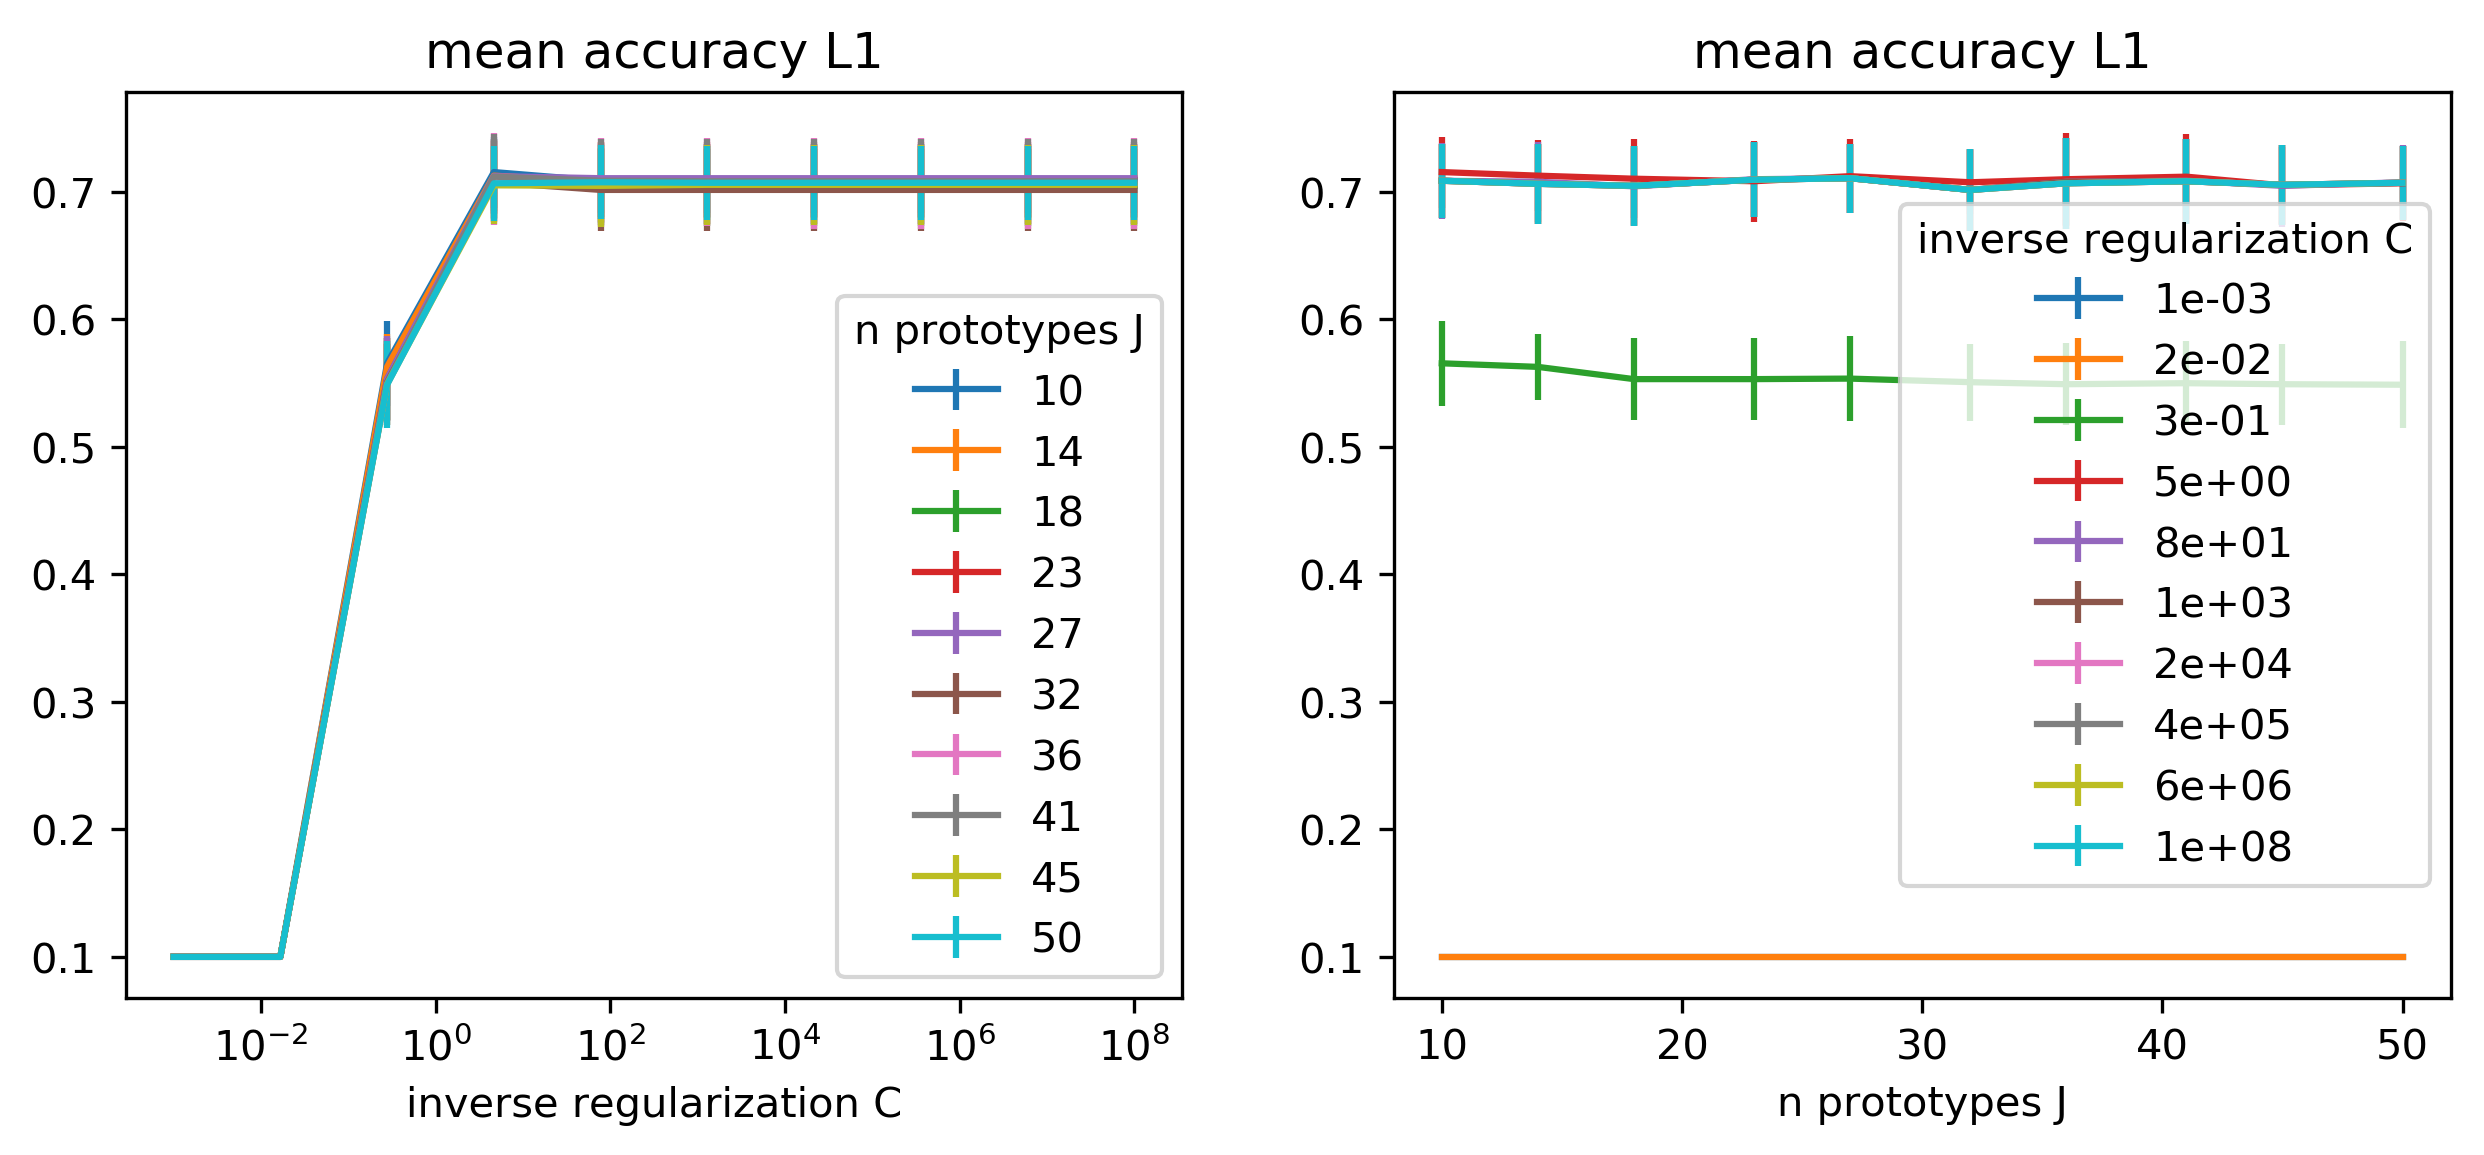

In [ ]:
reportl1.main_parameter_grids()

#### L2 penalty

In [ ]:
reportl2.wc_stats()
reportl2.report(X,y)

Wc sparsity @ tol=0.1 0.447998046875
Wc mean:  -3.2101266089767935e-13 std:  0.3129009088567722
best Params {'classify__C': 21544.346900318866, 'classify__penalty': 'l2', 'classify__shortcut': 'cat', 'classify__solver': 'lbfgs', 'classify__use_shortcut': True, 'cluster__class_weight': 0.0, 'cluster__n_clusters': 23}
mean acuracy of best cv model:  0.7128
best model train accuracy:  1.0
holdout test accuracy:  0.7344


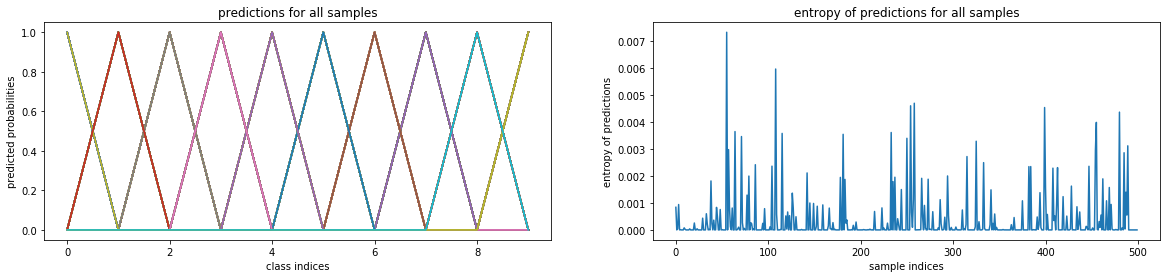

In [ ]:
reportl2.entropy_per_sample(X,y)
plt.gcf().set_size_inches(20,4)

proto per class:  [1.12577911 1.97365999 3.93921881 3.04927692 0.57924406 3.15099959
 0.59111766 4.68943864 1.87491696 2.02634826]


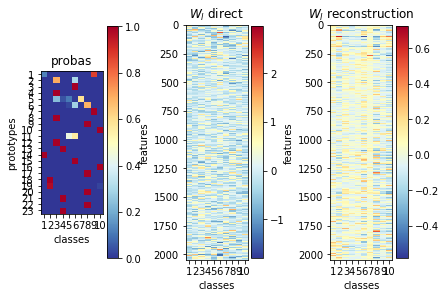

In [ ]:
reportl2.visualize_weights()

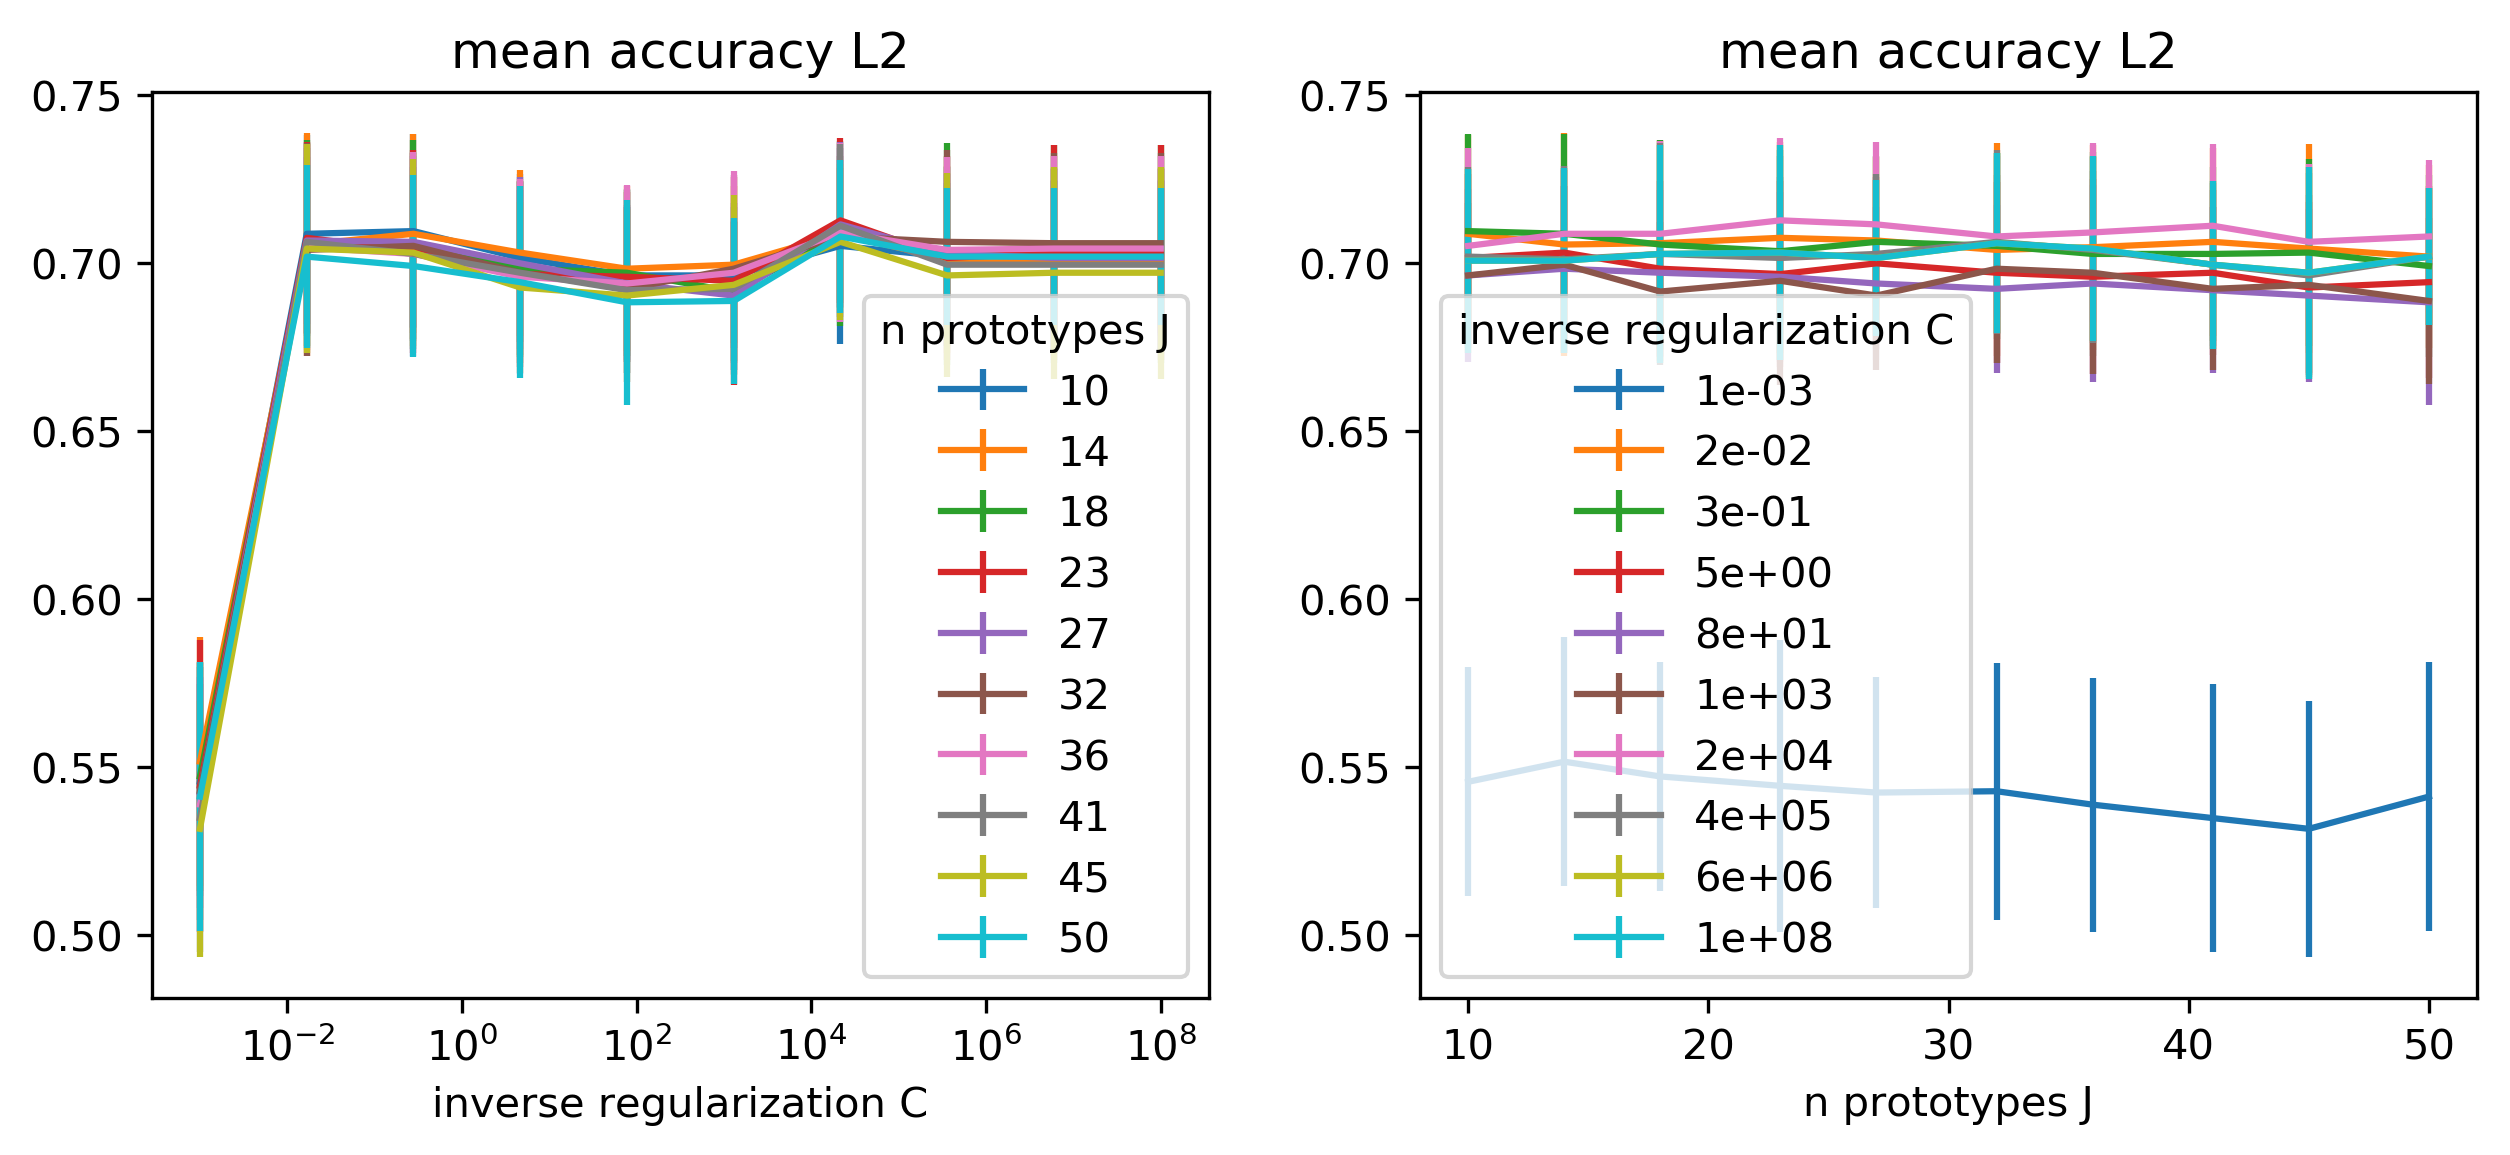

In [ ]:
reportl2.main_parameter_grids()

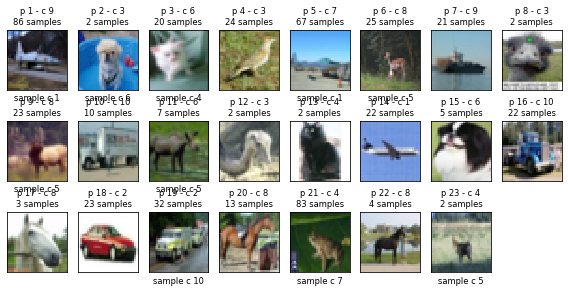

In [ ]:
reportl2.closest_images(X_imgs, X, y, show_distances=False)
fig = plt.gcf()
fig.set_size_inches(8,4)
plt.tight_layout()
reportl2.savefig('closest_images.eps')

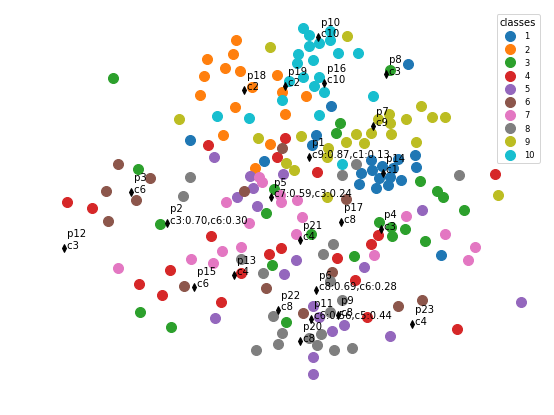

In [ ]:
reportl2.plot2D(X,y, method='tsne', cluster_limits=False, arrows=False,
               random_state=random_state)
fig = plt.gcf()
fig.set_size_inches(9,7)
reportl2.savefig('plot2D_tsne.eps')

## Adding a classification loss via using class labels as dimensions
Exploring a smaler range for the parameters already observed. Study class weight param.

In [ ]:
ex = Experiment(
        path = os.path.join(inpath, 'analysing_class_weight_models'),
        model_list=['l1_classweight','l2_classweight'],
        n_Cs=3, Cs_lim=(2,6),
        n_n_clusters=5, n_clusters_lim=(1,5),
        n_class_weights=5, class_weight_lim=(0,10),
        dataset = dataset,
        train_size=train_size,
        n_splits=1,
        n_classes=n_classes,
        random_seed=random_state)
out = ex.run_multiple_splits(return_models=True)
exp_info = out['info']
res_dict = out['results']
models = out['models']
dataset_obj = exp_info['dataset']
X_imgs, X, y = dataset_obj.gen_data()
skf, skf_cv = exp_info['skf'], exp_info['skf_cv']

{'model_list': ['l1_classweight', 'l2_classweight'], 'path': './prototype_results/cifar10_hparams/analysing_class_weight_models', 'dataset': <prototype_data.Cifar10 object at 0x7f1ff05dd5f8>, 'n_classes': 10, 'n_episodes': None, 'n_splits': 1, 'random_seed': 0, 'train_size': 500, 'skf': StratifiedShufflePredefinedTestSplit(n_splits=1, random_state=0,
                   test_fold=array([-1, -1, ...,  0,  0]), train_size=500), 'skf_cv': <sklearn.model_selection._split.RepeatedStratifiedKFold object at 0x7f206cdf1518>, 'n_jobs': 2, 'cluster_classify_kwargs': {'n_Cs': 3, 'Cs_lim': (2, 6), 'n_n_clusters': 5, 'n_clusters_lim': (1, 5), 'n_class_weights': 5, 'class_weight_lim': (0, 10), 'n_shortcut': 1, 'shortcut_lim': (0, 1), 'shortcut_scale': 'linear'}}
Results at ./prototype_results/cifar10_hparams/analysing_class_weight_models/1_splits_500_train_size/results.pd.pkl
Running models: ['l1_classweight', 'l2_classweight']
Fitting 10 folds for each of 75 candidates, totalling 750 fits


[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   39.1s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:  3.2min
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:  7.5min
[Parallel(n_jobs=2)]: Done 750 out of 750 | elapsed: 12.6min finished


Fitting 10 folds for each of 75 candidates, totalling 750 fits


[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   45.8s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:  3.6min
/mnt/Data/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:712: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:  8.4min
/mnt/Data/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:712: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/mnt/Data/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:712: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/mnt/Data/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:712: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", Convergen

/mnt/Data/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:712: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/mnt/Data/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:712: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/mnt/Data/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:712: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/mnt/Data/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:712: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/mnt/Data/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:712: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of

/mnt/Data/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:712: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/mnt/Data/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:712: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/mnt/Data/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:712: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/mnt/Data/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:712: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/mnt/Data/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:712: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of

/mnt/Data/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:712: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/mnt/Data/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:712: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/mnt/Data/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:712: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/mnt/Data/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:712: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/mnt/Data/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:712: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of

### Train split 0
#### L1

In [ ]:
reportl1 = Report('analysing_class_weight_models', models, model='l1_classweight', splitter=skf, N=N, directory=results_path)
reportl2 = Report('analysing_class_weight_models', models, model='l2_classweight', splitter=skf, N=N, directory=results_path)

In [ ]:
reportl1.wc_stats()
reportl1.report(X, y)

Wc sparsity @ tol=0.1 0.010000000000000009
Wc mean:  0.002964121499192531 std:  17.325037056048917
best Params {'classify__C': 10000.0, 'classify__penalty': 'l1', 'classify__shortcut': 0.0, 'classify__solver': 'saga', 'classify__tol': 0.1, 'classify__use_shortcut': False, 'cluster__class_weight': 7.5, 'cluster__n_clusters': 10}
mean acuracy of best cv model:  0.6916
best model train accuracy:  0.824
holdout test accuracy:  0.7206


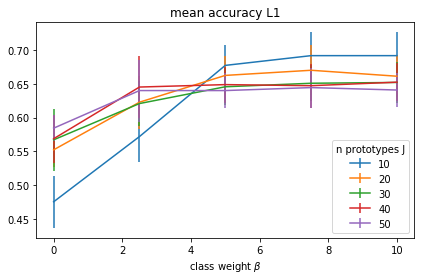

In [ ]:
reportl1.parameter_grid(index=['param_cluster__class_weight',],
    columns=['param_cluster__n_clusters'], fix='all')
plt.tight_layout()
reportl1.savefig('class_weight_n_clusters.eps')

#### L2

In [ ]:
reportl2.wc_stats()
reportl2.report(X,y)

Wc sparsity @ tol=0.1 0.030000000000000027
Wc mean:  2.176037128265307e-15 std:  11.92802279361168
best Params {'classify__C': 100.0, 'classify__penalty': 'l2', 'classify__shortcut': 0.0, 'classify__solver': 'lbfgs', 'classify__use_shortcut': False, 'cluster__class_weight': 7.5, 'cluster__n_clusters': 10}
mean acuracy of best cv model:  0.6876
best model train accuracy:  0.822
holdout test accuracy:  0.7185


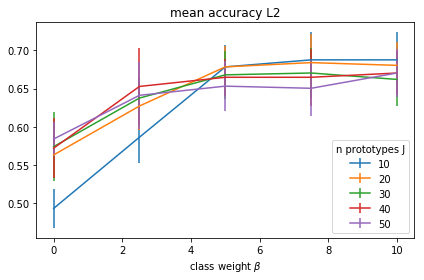

In [ ]:
reportl2.parameter_grid(index=['param_cluster__class_weight',],
    columns=['param_cluster__n_clusters'], fix='all')
plt.tight_layout()
reportl2.savefig('class_weight_n_clusters.eps')

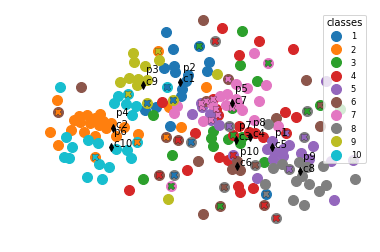

In [ ]:
np.random.seed(0)
reportl2.plot2D(X,y, method='tsne', perplexity=30, cluster_limits=False, arrows=False)

In [ ]:
reportl2.params()

best parameters:  {'classify__C': 100.0, 'classify__penalty': 'l2', 'classify__shortcut': 0.0, 'classify__solver': 'lbfgs', 'classify__use_shortcut': False, 'cluster__class_weight': 7.5, 'cluster__n_clusters': 10}


## Balancing between our model and a simple softmax with a shortcut
Model now has a shorcut from the features to the softmax layer. 
Shorcut value is between 0 (only our model) and 1 (only features+softmax)
Idealy approaching shortcut 1 should get us close to softmax perf.
If we have something better in between that means we can help the softmax.

In [ ]:
ex = Experiment(
        path = os.path.join(inpath, 'analysing_shortcut_model'),
        model_list=['l1_shortcut', 'l2_shortcut'],
        n_Cs=3, Cs_lim=(2,6),
        n_n_clusters=5, n_clusters_lim=(1,5),
        n_shortcut=5, 
        dataset = dataset,
        train_size=train_size,
        n_splits=1,
        n_classes=n_classes,
        random_seed=random_state)
out = ex.run_multiple_splits(return_models=True)
exp_info = out['info']
res_dict = out['results']
models = out['models']
dataset_obj = exp_info['dataset']
X_imgs, X, y = dataset_obj.gen_data()
skf, skf_cv = exp_info['skf'], exp_info['skf_cv']

{'model_list': ['l1_shortcut', 'l2_shortcut'], 'path': './prototype_results/cifar10_hparams/analysing_shortcut_model', 'dataset': <prototype_data.Cifar10 object at 0x7f206cb07dd8>, 'n_classes': 10, 'n_episodes': None, 'n_splits': 1, 'random_seed': 0, 'train_size': 500, 'skf': StratifiedShufflePredefinedTestSplit(n_splits=1, random_state=0,
                   test_fold=array([-1, -1, ...,  0,  0]), train_size=500), 'skf_cv': <sklearn.model_selection._split.RepeatedStratifiedKFold object at 0x7f206cb07eb8>, 'n_jobs': 2, 'cluster_classify_kwargs': {'n_Cs': 3, 'Cs_lim': (2, 6), 'n_n_clusters': 5, 'n_clusters_lim': (1, 5), 'n_class_weights': 3, 'class_weight_lim': (0.0, 2.0), 'n_shortcut': 5, 'shortcut_lim': (0, 1), 'shortcut_scale': 'linear'}}
Results at ./prototype_results/cifar10_hparams/analysing_shortcut_model/1_splits_500_train_size/results.pd.pkl
Running models: ['l1_shortcut', 'l2_shortcut']
Fitting 10 folds for each of 75 candidates, totalling 750 fits


/mnt/Data/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:712: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/mnt/Data/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:712: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/mnt/Data/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:712: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/mnt/Data/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:712: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/mnt/Data/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:712: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of

/mnt/Data/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:712: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/mnt/Data/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:712: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/mnt/Data/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:712: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/mnt/Data/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:712: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/mnt/Data/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:712: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of

/mnt/Data/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:712: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/mnt/Data/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:712: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/mnt/Data/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:712: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/mnt/Data/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:712: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/mnt/Data/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:712: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of

/mnt/Data/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:712: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/mnt/Data/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:712: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/mnt/Data/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:712: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/mnt/Data/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:712: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/mnt/Data/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:712: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of

Fitting 10 folds for each of 75 candidates, totalling 750 fits


[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   45.9s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:  3.4min
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:  7.7min
[Parallel(n_jobs=2)]: Done 750 out of 750 | elapsed: 12.9min finished


### Train split 0

In [ ]:
reportl1 = Report('analysing_shortcut_model', models, model='l1_shortcut', splitter=skf, N=N,directory=results_path)
reportl2 = Report('analysing_shortcut_model', models, model='l2_shortcut', splitter=skf, N=N,directory=results_path)

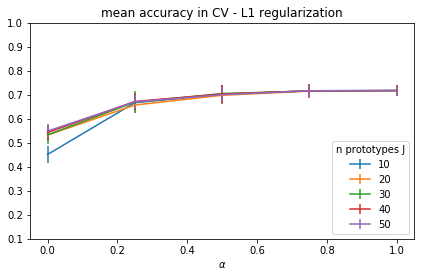

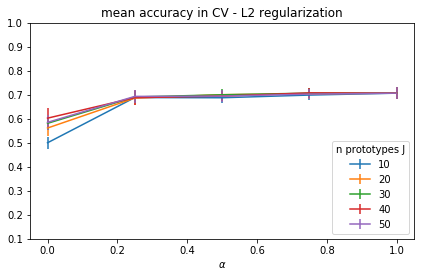

In [ ]:
reportl1.parameter_grid(index=['param_classify__shortcut'],
                               columns=['param_cluster__n_clusters'],
                               fix='all')
plt.ylim(0.1,1)
plt.tight_layout()
plt.title('mean accuracy in CV - L1 regularization')
plt.xscale('linear')
reportl1.savefig('shortcut_n_clusters.eps')


reportl2.parameter_grid(index=['param_classify__shortcut'],
                               columns=['param_cluster__n_clusters'],
                               fix='all')
plt.ylim(0.1,1)
plt.tight_layout()
plt.title('mean accuracy in CV - L2 regularization')
plt.xscale('linear')
reportl2.savefig('shortcut_n_clusters.eps')

#### L1

proto per class:  [1.25882637 1.51063725 0.6389963  0.58888683 0.3685469  1.8996106
 0.32208346 1.32220762 0.9329448  1.15725986]
best Params {'classify__C': 100.0, 'classify__penalty': 'l1', 'classify__shortcut': 1.0, 'classify__solver': 'saga', 'classify__tol': 0.1, 'classify__use_shortcut': True, 'cluster__class_weight': 0.0, 'cluster__n_clusters': 10}
mean acuracy of best cv model:  0.7188
best model train accuracy:  0.974
holdout test accuracy:  0.7527


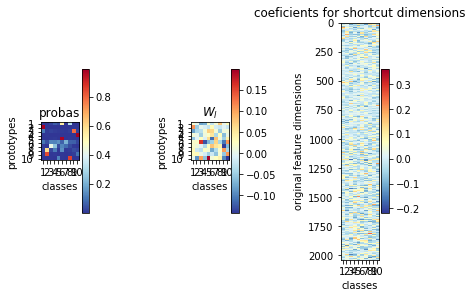

In [ ]:
reportl1.visualize_weights()
reportl1.report(X,y)

* Especially for n clsuters = n classes the shortcut helps the most
* hypothesis: 10 clusters is a too low dimensionality, too simple a model. Softmax over the original features is a much more complex model (extra 2048 weights!)

#### L2

proto per class:  [2.1802149  2.02290687 5.22425501 5.09631156 4.09091033 9.09415138
 2.18817821 5.09408485 3.00364294 2.00534394]
best Params {'classify__C': 10000.0, 'classify__penalty': 'l2', 'classify__shortcut': 0.75, 'classify__solver': 'lbfgs', 'classify__use_shortcut': True, 'cluster__class_weight': 0.0, 'cluster__n_clusters': 40}
mean acuracy of best cv model:  0.7091999999999999
best model train accuracy:  1.0
holdout test accuracy:  0.7387


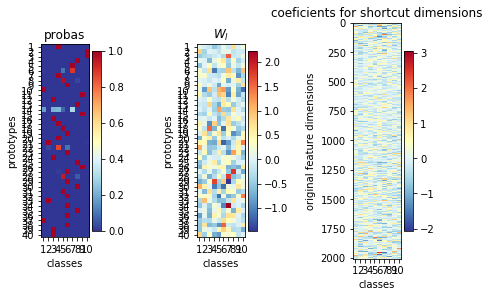

In [ ]:
reportl2.visualize_weights()
reportl2.report(X,y)

best parameters:  {'classify__C': 10000.0, 'classify__penalty': 'l2', 'classify__shortcut': 0.75, 'classify__solver': 'lbfgs', 'classify__use_shortcut': True, 'cluster__class_weight': 0.0, 'cluster__n_clusters': 40}


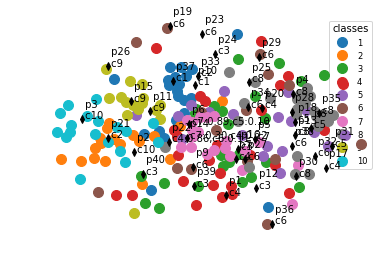

In [ ]:
np.random.seed(1)
reportl2.plot2D(X,y, method='tsne', perplexity=30)
reportl2.params()
reportl2.savefig('plot2D_tsne.eps')

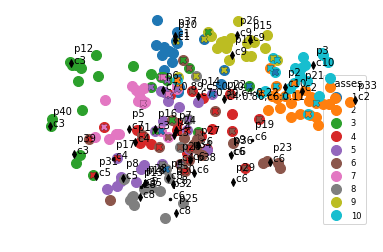

In [ ]:
np.random.seed(1)
reportl2.plot2D(X,y, method='tsne', perplexity=30, split='test')
reportl2.savefig('plot2D_tsne_test.eps')

## Class weight and shortcut togheter - do they help eachother?

In [61]:
ex = Experiment(
        path = os.path.join(inpath, 'analysing_full_model'),
        model_list=['l1_full', 'l2_full'],
        n_Cs=2, Cs_lim=(2,6),
        n_n_clusters=3, n_clusters_lim=(1,5),
        n_class_weights=3, class_weight_lim=(0,10),
        n_shortcut=5, 
        dataset = dataset,
        train_size=train_size,
        n_splits=1,
        n_classes=n_classes,
        random_seed=random_state)
out = ex.run_multiple_splits(return_models=True)
exp_info = out['info']
res_dict = out['results']
models = out['models']
dataset_obj = exp_info['dataset']
X_imgs, X, y = dataset_obj.gen_data()
skf, skf_cv = exp_info['skf'], exp_info['skf_cv']

{'model_list': ['l1_full', 'l2_full'], 'path': './prototype_results/cifar10_hparams/analysing_full_model', 'dataset': <prototype_data.Cifar10 object at 0x7f1ff0433208>, 'n_classes': 10, 'n_episodes': None, 'n_splits': 1, 'random_seed': 0, 'train_size': 500, 'skf': StratifiedShufflePredefinedTestSplit(n_splits=1, random_state=0,
                   test_fold=array([-1, -1, ...,  0,  0]), train_size=500), 'skf_cv': <sklearn.model_selection._split.RepeatedStratifiedKFold object at 0x7f1ff0433e10>, 'n_jobs': 2, 'cluster_classify_kwargs': {'n_Cs': 2, 'Cs_lim': (2, 6), 'n_n_clusters': 3, 'n_clusters_lim': (1, 5), 'n_class_weights': 3, 'class_weight_lim': (0, 10), 'n_shortcut': 5, 'shortcut_lim': (0, 1), 'shortcut_scale': 'linear'}}
Results at ./prototype_results/cifar10_hparams/analysing_full_model/1_splits_500_train_size/results.pd.pkl
Running models: ['l1_full', 'l2_full']
Fitting 10 folds for each of 90 candidates, totalling 900 fits


/mnt/Data/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:712: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/mnt/Data/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:712: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/mnt/Data/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:712: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/mnt/Data/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:712: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/mnt/Data/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:712: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of

/mnt/Data/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:712: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/mnt/Data/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:712: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/mnt/Data/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:712: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/mnt/Data/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:712: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/mnt/Data/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:712: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of

KeyboardInterrupt: 

### Train split 0
#### L1

In [ ]:
reportl1 = Report('analysing_full_model', models, model='l1_full', splitter=skf, N=N, directory=results_path)
reportl2 = Report('analysing_full_model', models, model='l2_full', splitter=skf, N=N, directory=results_path)

In [ ]:
n_clusters = np.unique(reportl1.model.cv_results_['param_cluster__n_clusters'].data)

In [ ]:
ts = []
terrs = []
for n in n_clusters:
    df, t, terr = reportl1.parameter_grid(
        index=['param_classify__shortcut'],
        columns=['param_cluster__class_weight'], 
        fix=dict(param_cluster__n_clusters=n, 
                 param_classify__C='best'),
        plot=False)
    ts.append(t)
    terrs.append(terr)

- when shortcut is strong, class weight does not matter 


In [ ]:
plt.figure(figsize=(10,4))
for i, t in enumerate(ts): 
    ax = plt.subplot(1,3,i+1)
    plt.title('n prototypes = %d' % n_clusters[i])
    t.plot(ax=ax, style=[':d',':.',':+']*20,yerr=terrs[i])
    plt.xscale('log')
    ax.set_xlabel(transform_label(ax.get_xlabel()))
    ax.set_xlabel(r'$\alpha$')
    new_title = transform_label(ax.get_legend().get_title().get_text())
    plt.legend(title=r'class weight $\beta$', loc='lower right')
    plt.ylim(0.21,0.98)
    plt.xscale('linear')
plt.tight_layout(pad=0.2,w_pad=1)
reportl1.savefig('shortcut_class_weight.eps')

#### L2

In [ ]:
n_clusters = np.unique(reportl2.model.cv_results_['param_cluster__n_clusters'].data)

In [ ]:
ts = []
terrs = []
for n in n_clusters:
    df, t, terr = reportl2.parameter_grid(
        index=['param_classify__shortcut'],
        columns=['param_cluster__class_weight'], 
        fix=dict(param_cluster__n_clusters=n, 
                 param_classify__C='best'),
            plot=False)

    ts.append(t)
    terrs.append(terr)

In [ ]:
plt.figure(figsize=(10,4))
for i, t in enumerate(ts): 
    ax = plt.subplot(1,3,i+1)
    plt.title('n prototypes = %d' % n_clusters[i])
    t.plot(ax=ax, style=[':d',':.',':+']*20,yerr=terrs[i])
    plt.xscale('log')
    ax.set_xlabel(transform_label(ax.get_xlabel()))
    ax.set_xlabel(r'$\alpha$')
    new_title = transform_label(ax.get_legend().get_title().get_text())
    plt.legend(title=r'class weight $\beta$', loc='lower right')
    plt.ylim(0.21,0.98)
    plt.xscale('linear')
plt.tight_layout(pad=0.2,w_pad=1)
reportl2.savefig('shortcut_class_weight.eps')

In [ ]:
reportl2.plot2D(X,y, method='tsne', perplexity=32, random_state=random_state)
reportl2.params()

In [ ]:
reportl2.plot2D(X,y, method='tsne', perplexity=35, split='test', random_state=random_state)